# Deep Learning with Tensorflow - tutorial

This Tensorflow tutorial is based on the following links:

- https://www.tensorflow.org/tutorials/quickstart/advanced
- https://www.tensorflow.org/guide/keras/custom_layers_and_models

The goal is to perform a classification task with the MNIST dataset:
Given the black and white picture of a number, a neural network will be trained to predict the correct number.

<img src="https://miro.medium.com/max/2200/1*XdCMCaHPt-pqtEibUfAnNw.png" alt="Drawing" style="width: 400px;"/>

# Initialisation

**First : change the runtime and hardware acceleration**

Runtime $\rightarrow$ Change runtime type

- Runtime type : Python 3
- Hardware accelerator : GPU

In [1]:
# Install TensorFlow 2.0 on Google Collab if needed
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
    pass

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt  

In [2]:
#Set the GPU you want to use
num_GPU = 0

import tensorflow as tf
print('Tensorflow version: ', tf.__version__)

gpus = tf.config.experimental.list_physical_devices("GPU")
print('Number of GPUs available :', len(gpus))

if num_GPU < len(gpus):
    tf.config.experimental.set_visible_devices(gpus[num_GPU], 'GPU')
    tf.config.experimental.set_memory_growth(gpus[num_GPU], True)
    print('Only GPU number', num_GPU, 'used')

Tensorflow version:  2.1.0
Number of GPUs available : 4
Only GPU number 0 used


# Tensorflow for beginners

![Keras](https://github.com/mgoutay/ml_course/blob/master/Images/Keras.png?raw=true)

Imports pre-made Keras Layers

In [3]:
from tensorflow import keras
from tensorflow.keras.layers import Flatten, Dense, Softmax
from tensorflow.keras import Model

## Dataset

Load and prepare the [MNIST dataset](http://yann.lecun.com/exdb/mnist/). 

It consists in B&W handwritten digits (matrices of size 28x28) and their corresponding labels

In [4]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

See what's inside the dataset, here with the three first digits and their corresponding labels :

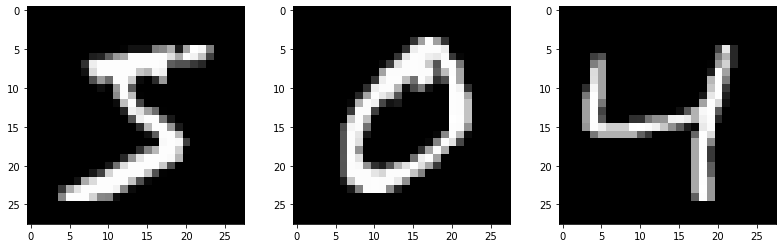

Corresponding labels: 5, 0, 4


In [5]:
fig = plt.figure(figsize=(3*4.5, 4))
for i in range(3):
    fig.add_subplot(1, 3, i+1)
    plt.imshow(x_train[i], cmap='gray')
plt.show()
print('Corresponding labels: '+ str(y_train[0])+ ', '+str(y_train[1])+ ', '+ str(y_train[2]))

## Building the model

Building a custom `tf.keras` Model (https://www.tensorflow.org/guide/keras/custom_layers_and_models):

A model has at least two methods:

- The `__init__` methods : here you define the model's attributes. All layers that will be used needs to be defined here
- the `call` method : here you write the forward pass of your model

`super` calls the parent's constructor. We won't go into details...

In [6]:
class MyModel(Model):
    def __init__(self):
        super(MyModel, self).__init__()
        
        # Define your model's attributes
        self.flat = Flatten(input_shape=(28, 28))
        self.d1 = Dense(64, activation='relu')
        self.d2 = Dense(10)
        self.smax = Softmax()
    
    def call(self, x):
        #write the forward pass
        self.x1 = self.flat(x)
        self.x2 = self.d1(self.x1)
        self.x3 = self.d2(self.x2)
        self.x4 = self.smax(self.x3)
        return self.x4

In [7]:
# Create an instance of the model
model = MyModel()

The output is a vector of probabilities.
Let's create a batch with the 3 first example in the dataset and predict their probabilities :

In [8]:
batch = x_train[:3]
probas = model(batch)
print(probas)

tf.Tensor(
[[0.13642977 0.07383027 0.10106032 0.14642367 0.09288557 0.10189948
  0.08882688 0.10454659 0.09274826 0.06134914]
 [0.1482578  0.05398727 0.13790743 0.11489546 0.06555498 0.07828671
  0.1302059  0.12391818 0.10116591 0.04582038]
 [0.12038255 0.08371846 0.11004859 0.14390941 0.09160648 0.07319326
  0.11261486 0.10843419 0.09984627 0.05624596]], shape=(3, 10), dtype=float32)


We can take the $\text{argmax}$ of each vector to see the digit with the highest predicted probability:

In [9]:
predictions = tf.argmax(probas, axis=1)
print('Predictions : ' + str(predictions.numpy()))
print('Labels : ' + str(y_train[:3]))

Predictions : [3 0 3]
Labels : [5 0 4]


The model is not trained and the predictions are totally wrong.

**So how do we train it?**

First, we need a loss function : for a classification task, it is the *categorical cross-entropy* :

<img src="https://github.com/mgoutay/ml_course/blob/master/Images/CE.JPG?raw=true" alt="Drawing" style="width: 700px;"/>

For one example in the batch :
$$ CE = \sum_{j=1}^{C} -p_{j} log (\hat{p}_{j})$$
Averaging on the entire batch :
$$ CE = \frac{1}{Bs} \sum_{i=1}^{Bs} \sum_{j=1}^{C} -p_{i,j} log (\hat{p}_{i,j})$$

**The cross-entropy is a measure of the difference between two probability distributions $p$ and $\hat{p}$**

In [10]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

Test the untrained network on the 3 first examples of the dataset:

In [11]:
loss_fn(y_train[:3], probas)

<tf.Tensor: shape=(), dtype=float32, numpy=2.194275>

The loss is BIG. That's normal, the NN is not trained.

So, let's train the model !

# Training

## Automatic differentiation

The `tf.GradientTape API` provides automatic differentiation.

All operations executed inside a gradient tape are recorded:

Let's say that we have a feature $x = 3$

A function implements $y=x^2$

We can find the derivative of $y$ w.r.t. $x$ : $\frac{dy}{dx} = 2x = 6$

In [12]:
x = tf.Variable(3.0)
with tf.GradientTape() as tape :
    y = tf.square(x)
dy_dx = tape.gradient(y,x)
print(dy_dx)

tf.Tensor(6.0, shape=(), dtype=float32)


## Datasets

Datasets are a cleaner way to manipulate large amount of date

Use `tf.data` to batch and shuffle the dataset:



In [13]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(128)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(128)

## The optimizer and loss function

Choose an optimizer and loss function for training:

In [14]:
optimizer = tf.keras.optimizers.Adam()
#loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

## The training loop

In [15]:
#Define the number of epochs
nb_epoch = 5

print('Loss after each epoch:')

for epoch in range(nb_epoch):
    
    # Iterate over the batches of the dataset.
    for step, (features, labels) in enumerate(train_ds):
        
        # Open a GradientTape.
        with tf.GradientTape() as tape:

            # Forward pass.
            probas = model(features)

            # Loss value for this batch.
            loss_value =  loss_fn(y_true=labels, y_pred=probas)

        # Get gradients of loss wrt the weights.
        gradients = tape.gradient(loss_value, model.trainable_weights)

        # Update the weights of our linear layer.
        optimizer.apply_gradients(zip(gradients, model.trainable_weights))
    
    #Test the model on the test datasets
    test_loss = 0.
    for step, (features, labels) in enumerate(test_ds):
        probas = model(features)
        test_loss += loss_fn(y_true=labels, y_pred=probas)
    print((test_loss/(step+1)).numpy(), end=', ')
print('Done')

Loss after each epoch:
0.23778343, 0.1761109, 0.14520392, 0.13236305, 0.11093433, Done


Let's predict again the first 3 examples of the dataset

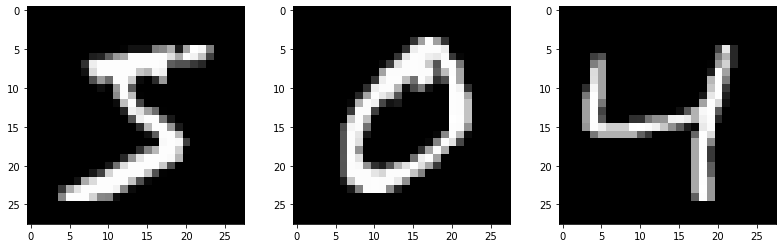

Predictions : 
tf.Tensor([5 0 4], shape=(3,), dtype=int64)


In [16]:
fig = plt.figure(figsize=(3*4.5, 4))
for i in range(3):
    fig.add_subplot(1, 3, i+1)
    plt.imshow(x_train[i], cmap='gray')
plt.show()
print('Predictions : ')

predictions = model(x_train[:3])
print(tf.argmax(predictions, axis=1))